# RBR bassin

Generate profile

In [1]:
import os, sys, pickle, glob
#import csv
import numpy as np
import matplotlib.pyplot as plt

import datetime

import pandas as pd

# cognac data and tools
import cognac.insitu as insi

In [12]:
file = '082218_20190416_1455_data.txt'
r = insi.rbr.rbr(file)

In [13]:
# trim data
r.trim(d=insi.utils.deployment(loglines=['16/04/2019 12:18:41','16/04/2019 12:22:40']))
#r.trim(d=insi.utils.deployment(loglines=['16/04/2019 12:48:22','16/04/2019 12:51:40']))

In [14]:
r.d.head()

,temperature,pressure,sea_pressure,depth
time,,,,
2019-04-16 12:18:41.000,11.270482,10.437158,0.304657,0.302785
2019-04-16 12:18:41.500,11.280488,10.435699,0.303198,0.301335
2019-04-16 12:18:42.000,11.286628,10.433530,0.301029,0.299179
2019-04-16 12:18:42.500,11.288003,10.438056,0.305555,0.303678
2019-04-16 12:18:43.000,11.280301,10.435074,0.302573,0.300714


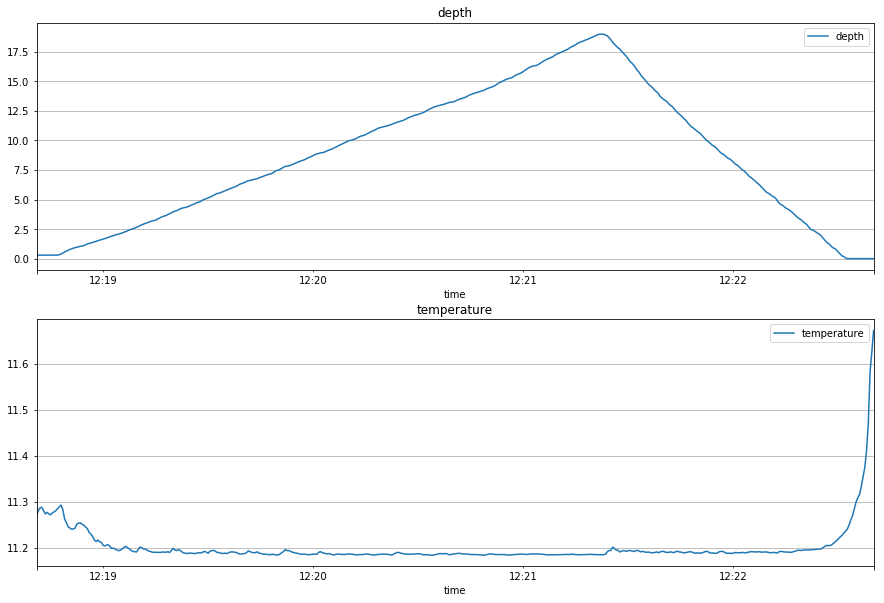

In [15]:
fig = plt.figure(figsize=(15,10))

# depth
ax = plt.subplot(211)
r['depth'].plot(ax=ax)
ax.set_title(r['depth'].name)    
ax.grid()
ax.legend()

# temperature
ax = plt.subplot(212)
r['temperature'].plot(ax=ax)
ax.set_title(r['temperature'].name)    
ax.grid()  
ax.legend()

In [16]:
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure

output_notebook()

TOOLS = 'pan,wheel_zoom,box_zoom,reset,help'

# subsample and compute speed
d = r.d.resample('10S').mean()
# 1T = 1 minute, 30S = 30 seconds

# create a new plot and add a renderer
s1 = figure(tools=TOOLS, plot_width=300, plot_height=300, title=None, 
              x_axis_type='datetime')
s1.line('time', 'temperature', source=d)
s1.add_tools(HoverTool(
    tooltips=[('time','@time{%T}'),('temperature','@{temperature}{%0.4f}'),],
    formatters={'time': 'datetime','temperature' : 'printf',},
    mode='vline'
    ))
    
s2 = figure(tools=TOOLS, plot_width=300, plot_height=300, title=None, 
               x_axis_type='datetime', x_range=s1.x_range)
s2.line('time', 'depth', source=d)
s2.add_tools(HoverTool(
    tooltips=[('time','@time{%T}'),('depth','@{depth}{%0.4f}'),],
    formatters={'time': 'datetime','depth' : 'printf',},
    mode='vline'
    ))

p = gridplot([[s1, s2]])

show(p)

Loading BokehJS ...

---

# bin by depth

In [17]:
def clean_and_depthbin(r, dp=1):
    
    dpdt = r.d.pressure.diff()/r.dt
    threshold = .1 # dbar/s
    d = r.d[dpdt>threshold] # select descent automatically
    #
    p = np.round(r.d.pressure/dp)
    d = d.groupby(by=p).mean()
    del d['pressure']
    return d

rb = clean_and_depthbin(r)

In [18]:
rb.head()

,temperature,sea_pressure,depth
pressure,,,
11.0,11.254861,0.780690,0.775893
12.0,11.204662,1.861746,1.850307
13.0,11.195361,2.834340,2.816924
14.0,11.192519,3.872505,3.848710
15.0,11.189677,4.906976,4.876826


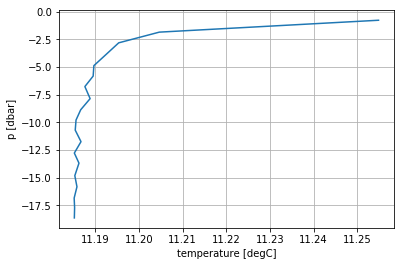

In [19]:
ax = plt.subplot(111)
ax.plot(rb.temperature, -rb.depth)
ax.set_ylabel('p [dbar]')
ax.set_xlabel('temperature [degC]')
ax.grid()

--- 
# store

In [11]:
rb.to_pickle('rbr_bassin.p')

In [12]:
# load and plot
r = pd.read_pickle('rbr_bassin.p')

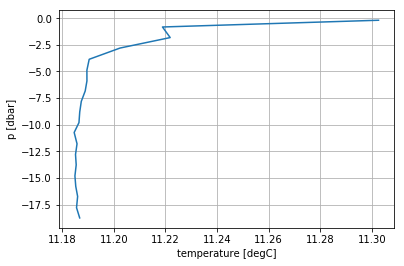

In [13]:
ax = plt.subplot(111)
ax.plot(r.temperature, -r.depth)
ax.set_ylabel('p [dbar]')
ax.set_xlabel('temperature [degC]')
ax.grid()